# 一、数据处理

In [1]:
import paddle
import os
import cv2
import numpy as np
class MyDataset(paddle.io.Dataset):
    """
    继承paddle.io.Dataset类
    """
    def __init__(self, data_dir, label_path, transform=None):
        """
        初始化数据集
        """
        super(MyDataset, self).__init__()
        self.datalist = []
        with open(label_path, encoding='utf-8') as f:
            for line in f.readlines():  # 对每一行
                image_path, label = line.strip().split("\t")  # 去除去除空白并且从制表符处分裂
                image_path = os.path.join(data_dir, image_path)  # 合并路径生成完整的图片文件路径
                # 将图片的文件路径以及标签组合起来纳入数据列表
                self.datalist.append([image_path, label])
        # 传入定义好的数据处理方法，并且作为一个属性
        self.transform = transform
    
    def __getitem__(self, index):
        """
        完成该函数可以在指定index下标时获取到数据
        """
        image_path, label = self.datalist[index]  # 解包
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # 读取单通道的灰度图
        image = image.astype("float32")  # 转换成paddle内部运行时用的数据类型
        if self.transform is not None:
            image = self.transform(image)  # 转换之后会多一个通道
            image = image[0]  # 由于只有一个通道，删去多余的维度
        # CrossEntropyLoss要求label格式为int，将Label格式转换为 int
        label = np.array([label],dtype = "int64")
        # 返回图像和对应标签
        return image, label

    def __len__(self):
        """
        实现len函数，返回数据集的样本总数
        """
        return len(self.datalist)
    

In [2]:
# mean (list tuple，可选) - 用于每个通道归一化的均值。
# std (listltuple，可选) - 用于每个通道归一化的标准差值.
# data format (str，可选) - 数据的格式，必须为HWC 或CHW。 默认值为CHW。
# 定义图像归一化处理方法，这里的CHW指图像格式需为 [C通道数，H图像高度，w图像宽度]
transform = paddle.vision.transforms.Normalize(mean=[127.5], std=[127.5], data_format="CHW")
mnist_path = './data/data179656/mnist'
train_dataset = MyDataset(os.path.join(mnist_path, 'train'), os.path.join(mnist_path, 'train/label.txt'), transform)
test_dataset = MyDataset(os.path.join(mnist_path, 'val'), os.path.join(mnist_path, 'val/label.txt'), transform)
# 打印数据集样本数
print('train_dataset_images:', len(train_dataset))
print("test_dataset_images:", len(test_dataset))


train_dataset_images: 60000
test_dataset_images: 10000


In [3]:
import matplotlib.pyplot as plt
# 定义并初始化数据读取器
train_loader = paddle.io.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=1)
# 调用 DataLoader 迭代读取数据
for batch_id, (images, labels) in enumerate(train_loader):
    print(f"batch id: {batch_id}, 训练数据shape: {images.shape}, 训练标签shape: {labels.shape}")
    plt.figure(figsize=(2,2))
    i = 60
    plt.imshow(images[i])
    print("label:", labels[i].item())
    break
    

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


batch id: 0, 训练数据shape: [64, 28, 28], 训练标签shape: [64, 1]
label: 6


W1214 15:33:55.187888  1175 gpu_resources.cc:61] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.2, Runtime API Version: 11.2
W1214 15:33:55.193331  1175 gpu_resources.cc:91] device: 0, cuDNN Version: 8.2.
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:425: DeprecationWarning: np.asscalar(a) is deprecated since 

# 二、模型设计

In [4]:
class MyDNN(paddle.nn.Layer):
    def __init__(self):
        super(MyDNN, self).__init__()
        self.linear1 = paddle.nn.Linear(in_features=1*28*28, out_features=50)
        self.relu1 = paddle.nn.ReLU()
        self.linear2 = paddle.nn.Linear(in_features=50, out_features=50)
        self.relu2 = paddle.nn.ReLU()
        self.linear3 = paddle.nn.Linear(in_features=50, out_features=10)
        self.softmax = paddle.nn.Softmax()
    
    # forward 定义执行实际运行时网络的执行逻辑
    def forward(self, input):
        # -1 表示这个维度的值是从x的元素总数和剩余维度推断出来的，有且只能有一个维度设置为-1
        x = paddle.reshape(input, shape=[-1,1*28*28])
        x = self.relu1(self.linear1(x))
        x = self.relu2(self.linear2(x))
        return self.softmax(self.linear3(x))


# 三、模型训练

In [5]:
t_loss = []
t_acc = []

myDNN = MyDNN()
epoch = 10
optimizer = paddle.optimizer.Adam(learning_rate=0.001, parameters=myDNN.parameters())  # Adam优化器
loss_func = paddle.nn.CrossEntropyLoss()  # 设置损失函数
myDNN.train()  # 将myDnn模型及其所有子层设置为训练模式。这只会影响某些模块，如Dropout和BatchNorm。
for epoch_id in range(epoch):
    for batch_id, (images, labels) in enumerate(train_loader):
        predicts = myDNN(images)   # 预测结果
        loss = loss_func(predicts, labels)  # 计算损失
        acc = paddle.metric.accuracy(predicts, labels)  # 计算准确率
        # 记录loss和acc
        t_loss.append(loss.numpy())
        t_acc.append(acc.numpy())
        loss.backward()  #反向传播
        # 打印训练信息
        if (batch_id + 1) % 100 == 0:
            print(f"epoch:{epoch_id + 1}/{epoch}, batch_id:{batch_id + 1}, loss:{loss.numpy()}\t, accuracy:{acc.numpy()}")
        optimizer.step()  # 更新参数
        optimizer.clear_grad()  # 梯度清零


epoch:1/10, batch_id:100, loss:[1.7057056]	, accuracy:[0.765625]
epoch:1/10, batch_id:200, loss:[1.7157594]	, accuracy:[0.78125]
epoch:1/10, batch_id:300, loss:[1.6270268]	, accuracy:[0.859375]
epoch:1/10, batch_id:400, loss:[1.6775751]	, accuracy:[0.78125]
epoch:1/10, batch_id:500, loss:[1.674758]	, accuracy:[0.796875]
epoch:1/10, batch_id:600, loss:[1.6527327]	, accuracy:[0.8125]
epoch:1/10, batch_id:700, loss:[1.712549]	, accuracy:[0.75]
epoch:1/10, batch_id:800, loss:[1.6328678]	, accuracy:[0.828125]
epoch:1/10, batch_id:900, loss:[1.620453]	, accuracy:[0.84375]
epoch:2/10, batch_id:100, loss:[1.6740692]	, accuracy:[0.78125]
epoch:2/10, batch_id:200, loss:[1.6640438]	, accuracy:[0.796875]
epoch:2/10, batch_id:300, loss:[1.6593988]	, accuracy:[0.8125]
epoch:2/10, batch_id:400, loss:[1.7307248]	, accuracy:[0.734375]
epoch:2/10, batch_id:500, loss:[1.5910859]	, accuracy:[0.875]
epoch:2/10, batch_id:600, loss:[1.6870292]	, accuracy:[0.796875]
epoch:2/10, batch_id:700, loss:[1.6026671]	

# 四、模型评估与推理

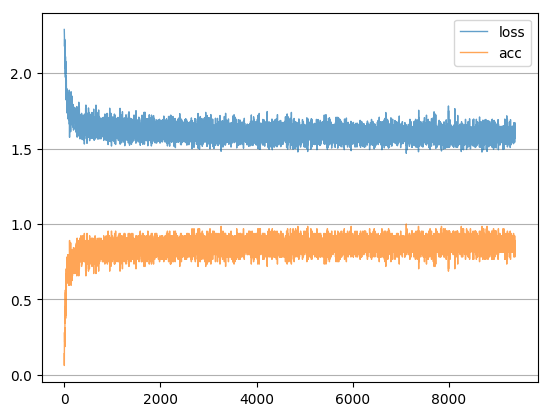

In [31]:
plt.plot(t_loss, label='loss', linewidth = 1, alpha=0.7)
plt.plot(t_acc, label='acc', linewidth = 1, alpha=0.7)
plt.grid(axis='y')
plt.legend()  # 显示对应
plt.show()

batch_id:30, loss:[1.5875785]	, accuracy:[0.875]
batch_id:60, loss:[1.6520193]	, accuracy:[0.8125]
batch_id:90, loss:[1.6186035]	, accuracy:[0.84375]
batch_id:120, loss:[1.5670494]	, accuracy:[0.890625]
batch_id:150, loss:[1.5846488]	, accuracy:[0.875]
true:7, predict:7


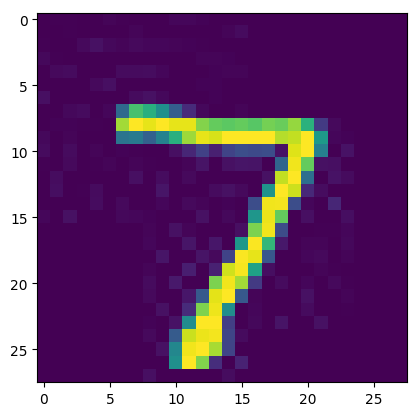

In [7]:
# 加载测试数据集
test_loader = paddle.io.DataLoader(test_dataset, batch_size=64, drop_last=True)
myDNN.eval()  # 将该模型及其所有子层设置为预测模式。这只会影响某些模块，如Dropout和BatchNorm
for batch_id, (images, labels) in enumerate(test_loader):
    predicts = myDNN(images)  # 预测结果
    loss = loss_func(predicts, labels)
    acc = paddle.metric.accuracy(predicts, labels)  # 计算损失与精度
    if (batch_id + 1) % 30 == 0:
        print(f"batch_id:{batch_id + 1}, loss:{loss.numpy()}\t, accuracy:{acc.numpy()}")
# 从测试集中取出一组数据
images_, labels_ = test_loader().next()
i = 0
predict_label = myDNN(images_)[i].argmax()  #执行推理并打印结果
print(f"true:{labels_[i].item()}, predict:{predict_label[i].item()}")
plt.imshow(images_[i])

In [8]:
paddle.save(myDNN.state_dict(), "LinearNet_LayerParams.pdparams")  # 保存Layer参数
paddle.save(optimizer.state_dict(), "Optimizer_AdamParams.adopt")  # 保存优化器参数

In [9]:
# 载入模型参数、优化器参数和最后一个epoch保存的检查点
layer_dict = paddle.load("LinearNet_LayerParams.pdparams")
opti_dict = paddle.load("Optimizer_AdamParams.adopt")

myNet = MyDNN()  # 初始化一个新的网络
myNet.set_state_dict(layer_dict)  # 将load后的参数与模型关联起来
# 初始化一个新的优化函数
optimizer2 = paddle.optimizer.Adam(learning_rate=0.001, parameters=myNet.parameters())
optimizer2.set_state_dict(opti_dict)  # 载入数据

batch_id:30, loss:[1.5875785]	, accuracy:[0.875]
batch_id:60, loss:[1.6520193]	, accuracy:[0.8125]
batch_id:90, loss:[1.6186035]	, accuracy:[0.84375]
batch_id:120, loss:[1.5670494]	, accuracy:[0.890625]
batch_id:150, loss:[1.5846488]	, accuracy:[0.875]
true:3, predict:3


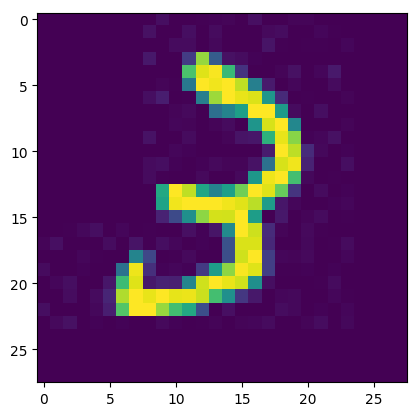

In [10]:
# 给新生成且载入了数据的网络进行测试，重复之前的测试代码
myNet.eval()
for batch_id, (images, labels) in enumerate(test_loader):
    predicts = myNet(images)
    loss = loss_func(predicts, labels)
    acc = paddle.metric.accuracy(predicts, labels)
    if (batch_id + 1) % 30 == 0:
        print(f"batch_id:{batch_id + 1}, loss:{loss.numpy()}\t, accuracy:{acc.numpy()}")
images_, labels_ = test_loader().next()
i = -1
predict_label = myDNN(images_)[i].argmax()
print(f"true:{labels_[i].item()}, predict:{predict_label[i].item()}")
plt.imshow(images_[i])